In [142]:
from dataclasses import dataclass

import numpy as np
import networkx as nx

import torch
import pytorch_lightning as pl

from torch.utils.data import DataLoader
from tensordict import TensorDict

from castle.datasets import DAG, IIDSimulation 
from castle.common import GraphDAG
from castle.metrics import MetricsDAG

import causica.distributions as cd

from causica.functional_relationships import ICGNN
from causica.training.auglag import AugLagLossCalculator, AugLagLR, AugLagLRConfig
from causica.graph.dag_constraint import calculate_dagness

from causica.datasets.variable_types import VariableTypeEnum
from causica.datasets.tensordict_utils import tensordict_shapes

import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

In [143]:
# Set device
device = 'cuda' if torch.cuda.is_available() else 'cpu'
# device = 'cpu'

In [144]:
COLORS = [
    '#00B0F0',
    '#FF0000',
    '#B0F000'
]

In [145]:
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

# Chapter 14


In [146]:
# Set random seed
SEED = 11
np.random.seed(SEED)
pl.seed_everything(SEED)  

Global seed set to 11


11

## DECI

### Data & configuration

In [147]:
nx.__version__

'2.8.7'

In [148]:
# Generate a scale-free adjacency matrix
adj_matrix = DAG.scale_free(
    n_nodes=4,
    n_edges=6,
    seed=SEED
)

# Generate the simulation
dataset = IIDSimulation(
    W=adj_matrix, 
    n=5000, 
    method='nonlinear', 
    sem_type='mim'
)

2023-10-21 16:19:18,204 - c:\Users\jakep\Coding\miniconda3\envs\causal_book_py39_cuda117\lib\site-packages\castle\datasets\simulator.py[line:270] - INFO: Finished synthetic dataset


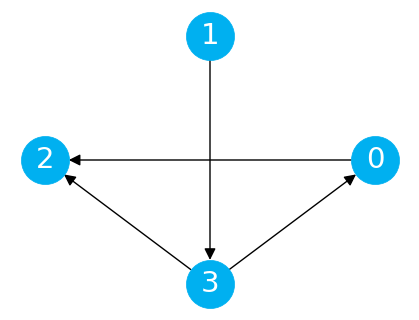

In [149]:
# Plot the graph
g = nx.DiGraph(adj_matrix)

plt.figure(figsize=(4, 3))
nx.draw(
    G=g,
    node_color=COLORS[0],
    node_size=1200,
    arrowsize=17,
    with_labels=True,
    font_color='white',
    font_size=21,
    pos=nx.circular_layout(g)
)

In [150]:
# Training config
@dataclass(frozen=True)
class TrainingConfig:
    noise_dist=cd.ContinuousNoiseDist.SPLINE
    batch_size=512
    max_epoch=500
    gumbel_temp=0.25
    averaging_period=10
    prior_sparsity_lambda=5.0
    init_rho=1.0
    init_alpha=0.0
        
training_config = TrainingConfig()
auglag_config = AugLagLRConfig()

In [151]:
# Cast data to torch tensors
data_tensors = {}

for i in range(dataset.X.shape[1]):
    data_tensors[f'x{i}'] = torch.tensor(dataset.X[:, i].reshape(-1, 1))
    
dataset_train = TensorDict(data_tensors, torch.Size([dataset.X.shape[0]]))
    
# Move the entire dataset to the device (for big datasets move to device by batch within training loop)
dataset_train = dataset_train.apply(lambda t: t.to(dtype=torch.float32, device=device))

# Create loader
dataloader_train = DataLoader(
    dataset=dataset_train,
    collate_fn=lambda x: x,
    batch_size=training_config.batch_size,
    shuffle=True,
    drop_last=False,
)

dataset_train

TensorDict(
    fields={
        x0: Tensor(shape=torch.Size([5000, 1]), device=cuda:0, dtype=torch.float32, is_shared=True),
        x1: Tensor(shape=torch.Size([5000, 1]), device=cuda:0, dtype=torch.float32, is_shared=True),
        x2: Tensor(shape=torch.Size([5000, 1]), device=cuda:0, dtype=torch.float32, is_shared=True),
        x3: Tensor(shape=torch.Size([5000, 1]), device=cuda:0, dtype=torch.float32, is_shared=True)},
    batch_size=torch.Size([5000]),
    device=None,
    is_shared=False)

### Expert knowledge

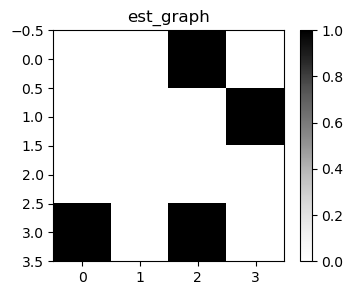

In [152]:
# Plot the true adj matrix
plt.style.use('default')
GraphDAG(adj_matrix)
plt.show()

In [153]:
# Encode our strong belief about the existence of the edge (3, 0) 
# And lack of existence of edge (0, 3)
expert_matrix = torch.tensor(np.zeros(adj_matrix.shape))

# Encode the edge knowledge
expert_matrix[3, 0] = 1.

# Create a relevancew mask
relevance_mask = expert_matrix.clone()
relevance_mask[0, 3] = 1.

# Create a confidence matrix
confidence_matrix = relevance_mask.clone()

In [154]:
# Encapsulate everything within the expert knowledge container
expert_knowledge = cd.ExpertGraphContainer(
    dag=expert_matrix,
    mask=relevance_mask,
    confidence=confidence_matrix,
    scale=5.
)

In [155]:
num_nodes = len(dataset_train.keys())

# Define the prior
prior = cd.GibbsDAGPrior(
    num_nodes=num_nodes, 
    sparsity_lambda=training_config.prior_sparsity_lambda,
    expert_graph_container=expert_knowledge
)

prior._expert_graph_container = prior._expert_graph_container.to(device)
prior._expert_graph_container.confidence = prior._expert_graph_container.confidence.to(device)

In [156]:
# Define the adjaceny module
adjacency_dist = cd.ENCOAdjacencyDistributionModule(num_nodes)

#Define the functional module
icgnn = ICGNN(
    variables=tensordict_shapes(dataset_train),
    embedding_size=8, #32,
    out_dim_g=8, #32,
    norm_layer=torch.nn.LayerNorm,
    res_connection=True,
)

# Define the noise module
types_dict = {var_name: VariableTypeEnum.CONTINUOUS for var_name in dataset_train.keys()}

noise_submodules = cd.create_noise_modules(
    shapes=tensordict_shapes(dataset_train), 
    types=types_dict, 
    continuous_noise_dist=training_config.noise_dist
)

noise_module = cd.JointNoiseModule(noise_submodules)

In [157]:
noise_submodules

{'x0': SplineNoiseModule(
   (composite_spline_layers): ModuleList(
     (0-1): 2 x CompositeSplineLayer()
   )
 ),
 'x1': SplineNoiseModule(
   (composite_spline_layers): ModuleList(
     (0-1): 2 x CompositeSplineLayer()
   )
 ),
 'x2': SplineNoiseModule(
   (composite_spline_layers): ModuleList(
     (0-1): 2 x CompositeSplineLayer()
   )
 ),
 'x3': SplineNoiseModule(
   (composite_spline_layers): ModuleList(
     (0-1): 2 x CompositeSplineLayer()
   )
 )}

In [158]:
?cd.SEMDistributionModule

Init signature:
cd.SEMDistributionModule(
    adjacency_module: causica.distributions.distribution_module.DistributionModule[causica.distributions.adjacency.adjacency_distributions.AdjacencyDistribution],
    functional_relationships: causica.functional_relationships.functional_relationships.FunctionalRelationships,
    noise_module: causica.distributions.noise.joint.JointNoiseModule,
)
Docstring:      Represents a SEMDistribution with learnable parameters.
Init docstring: Initializes internal Module state, shared by both nn.Module and ScriptModule.
File:           c:\users\jakep\coding\miniconda3\envs\causal_book_py39_cuda117\lib\site-packages\causica\distributions\sem_distribution.py
Type:           type
Subclasses:     

In [159]:
# Combine all SEM modules
sem_module = cd.SEMDistributionModule(
    adjacency_module=adjacency_dist, 
    functional_relationships=icgnn, 
    noise_module=noise_module)

sem_module.to(device)

SEMDistributionModule(
  (adjacency_module): ENCOAdjacencyDistributionModule()
  (functional_relationships): ICGNN(
    (nn): FGNNI(
      (g): Sequential(
        (0): Sequential(
          (0): Linear(in_features=12, out_features=64, bias=True)
          (1): LeakyReLU(negative_slope=0.01)
        )
        (1): _ResBlock(
          (block): Sequential(
            (0): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
            (1): Linear(in_features=64, out_features=64, bias=True)
            (2): LeakyReLU(negative_slope=0.01)
          )
        )
        (2): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
        (3): Linear(in_features=64, out_features=8, bias=True)
        (4): Identity()
      )
      (f): Sequential(
        (0): Sequential(
          (0): Linear(in_features=16, out_features=64, bias=True)
          (1): LeakyReLU(negative_slope=0.01)
        )
        (1): _ResBlock(
          (block): Sequential(
            (0): LayerNorm((64,), eps=1e-05, ele

In [160]:
modules = {
    "icgnn": sem_module.functional_relationships,
    "vardist": sem_module.adjacency_module,
    "noise_dist": sem_module.noise_module,
}

parameter_list = [
    {"params": module.parameters(), "lr": auglag_config.lr_init_dict[name], "name": name}
    for name, module in modules.items()
]

# Define the optimizer
optimizer = torch.optim.Adam(parameter_list)

In [161]:
# Define the augmented Lagrangian loss objects
scheduler = AugLagLR(config=auglag_config)

auglag_loss = AugLagLossCalculator(
    init_alpha=training_config.init_alpha, 
    init_rho=training_config.init_rho
)

c:\Users\jakep\Coding\miniconda3\envs\causal_book_py39_cuda117\lib\site-packages\torch\distributions\distribution.py:53: UserWarning: <class 'causica.distributions.noise.joint.JointNoise'> does not define `arg_constraints`. Please set `arg_constraints = {}` or initialize the distribution with `validate_args=False` to turn off validation.
  warnings.warn(


epoch:0 loss:8.1087 nll:8.107 dagness:0.00000 num_edges:2 alpha:0 rho:1 step:0|1 num_lr_updates:0


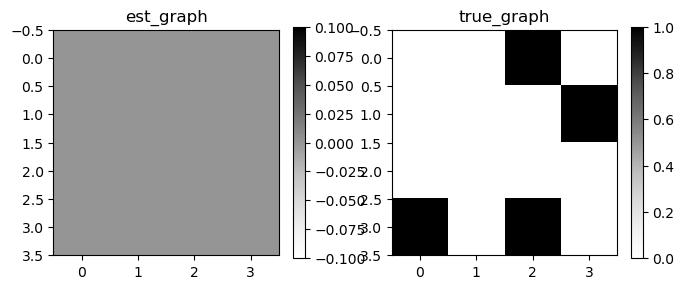

c:\Users\jakep\Coding\miniconda3\envs\causal_book_py39_cuda117\lib\site-packages\torch\distributions\distribution.py:53: UserWarning: <class 'causica.distributions.noise.joint.JointNoise'> does not define `arg_constraints`. Please set `arg_constraints = {}` or initialize the distribution with `validate_args=False` to turn off validation.
  warnings.warn(


epoch:10 loss:6.3019 nll:6.2973 dagness:0.50418 num_edges:5 alpha:0 rho:1 step:0|101 num_lr_updates:0


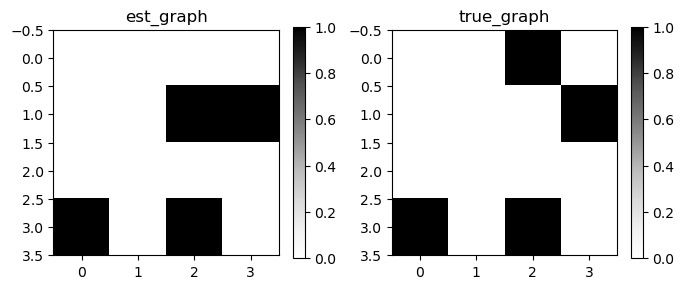

c:\Users\jakep\Coding\miniconda3\envs\causal_book_py39_cuda117\lib\site-packages\torch\distributions\distribution.py:53: UserWarning: <class 'causica.distributions.noise.joint.JointNoise'> does not define `arg_constraints`. Please set `arg_constraints = {}` or initialize the distribution with `validate_args=False` to turn off validation.
  warnings.warn(


epoch:20 loss:5.9562 nll:5.9526 dagness:0.00000 num_edges:4 alpha:0 rho:1 step:0|201 num_lr_updates:0


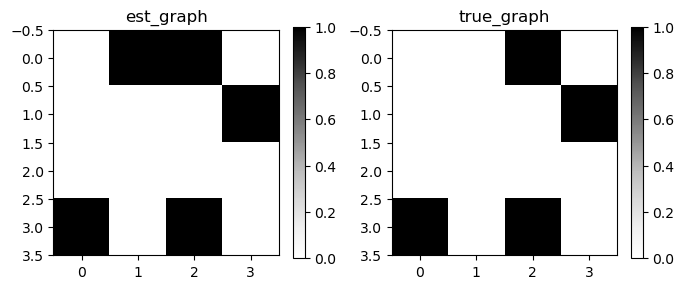

c:\Users\jakep\Coding\miniconda3\envs\causal_book_py39_cuda117\lib\site-packages\torch\distributions\distribution.py:53: UserWarning: <class 'causica.distributions.noise.joint.JointNoise'> does not define `arg_constraints`. Please set `arg_constraints = {}` or initialize the distribution with `validate_args=False` to turn off validation.
  warnings.warn(


epoch:30 loss:5.7825 nll:5.778 dagness:0.50418 num_edges:5 alpha:0 rho:1 step:0|301 num_lr_updates:0


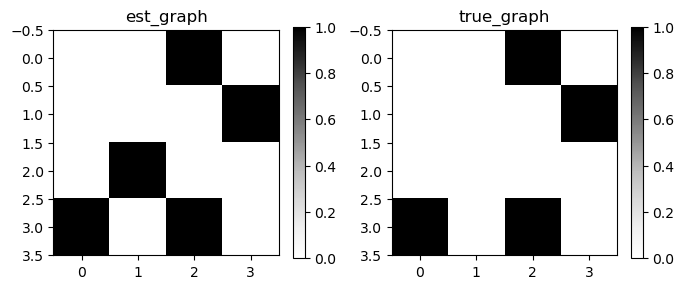

c:\Users\jakep\Coding\miniconda3\envs\causal_book_py39_cuda117\lib\site-packages\torch\distributions\distribution.py:53: UserWarning: <class 'causica.distributions.noise.joint.JointNoise'> does not define `arg_constraints`. Please set `arg_constraints = {}` or initialize the distribution with `validate_args=False` to turn off validation.
  warnings.warn(


epoch:40 loss:5.8931 nll:5.8873 dagness:1.18629 num_edges:6 alpha:0 rho:1 step:0|401 num_lr_updates:0


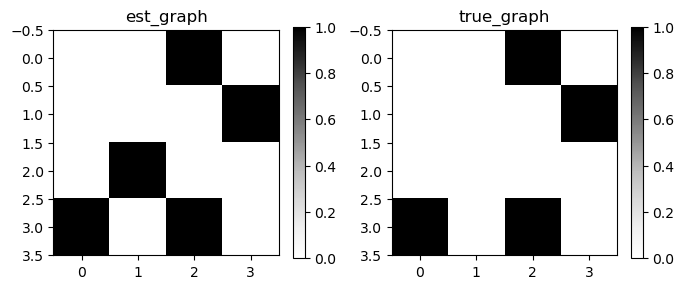

c:\Users\jakep\Coding\miniconda3\envs\causal_book_py39_cuda117\lib\site-packages\torch\distributions\distribution.py:53: UserWarning: <class 'causica.distributions.noise.joint.JointNoise'> does not define `arg_constraints`. Please set `arg_constraints = {}` or initialize the distribution with `validate_args=False` to turn off validation.
  warnings.warn(


epoch:50 loss:6.8067 nll:6.8019 dagness:0.67233 num_edges:5 alpha:0 rho:1 step:0|501 num_lr_updates:0


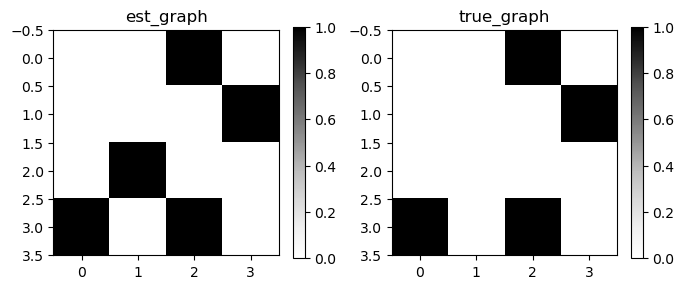

c:\Users\jakep\Coding\miniconda3\envs\causal_book_py39_cuda117\lib\site-packages\torch\distributions\distribution.py:53: UserWarning: <class 'causica.distributions.noise.joint.JointNoise'> does not define `arg_constraints`. Please set `arg_constraints = {}` or initialize the distribution with `validate_args=False` to turn off validation.
  warnings.warn(


epoch:60 loss:6.647 nll:6.6412 dagness:1.18629 num_edges:6 alpha:0 rho:1 step:0|601 num_lr_updates:1


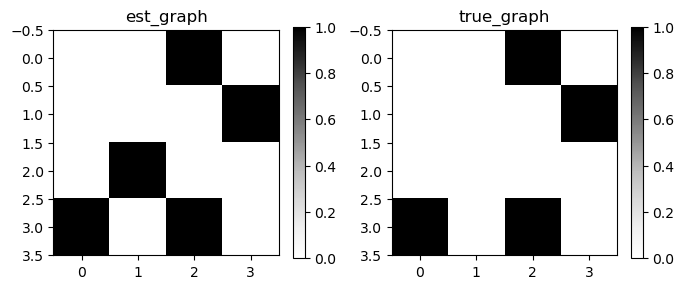

c:\Users\jakep\Coding\miniconda3\envs\causal_book_py39_cuda117\lib\site-packages\torch\distributions\distribution.py:53: UserWarning: <class 'causica.distributions.noise.joint.JointNoise'> does not define `arg_constraints`. Please set `arg_constraints = {}` or initialize the distribution with `validate_args=False` to turn off validation.
  warnings.warn(


epoch:70 loss:6.8776 nll:6.8728 dagness:0.67233 num_edges:5 alpha:0 rho:1 step:0|701 num_lr_updates:1


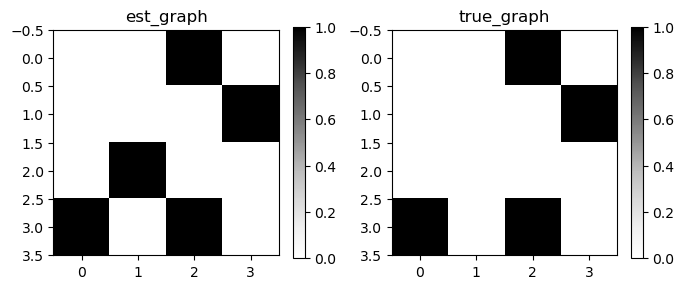

c:\Users\jakep\Coding\miniconda3\envs\causal_book_py39_cuda117\lib\site-packages\torch\distributions\distribution.py:53: UserWarning: <class 'causica.distributions.noise.joint.JointNoise'> does not define `arg_constraints`. Please set `arg_constraints = {}` or initialize the distribution with `validate_args=False` to turn off validation.
  warnings.warn(


epoch:80 loss:7.3316 nll:7.3258 dagness:1.18629 num_edges:6 alpha:0 rho:1 step:0|801 num_lr_updates:1


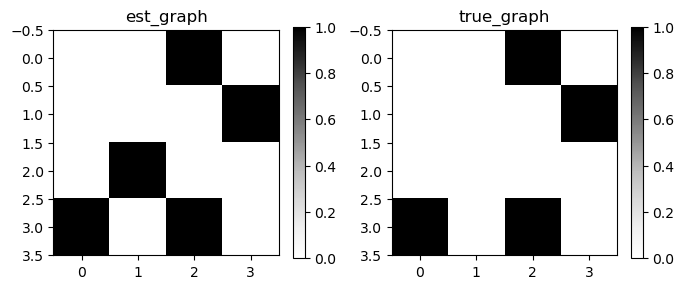

c:\Users\jakep\Coding\miniconda3\envs\causal_book_py39_cuda117\lib\site-packages\torch\distributions\distribution.py:53: UserWarning: <class 'causica.distributions.noise.joint.JointNoise'> does not define `arg_constraints`. Please set `arg_constraints = {}` or initialize the distribution with `validate_args=False` to turn off validation.
  warnings.warn(


Updating alpha to: 0.672332763671875
epoch:90 loss:10.197 nll:10.192 dagness:0.67233 num_edges:5 alpha:0.67233 rho:1 step:1|86 num_lr_updates:0


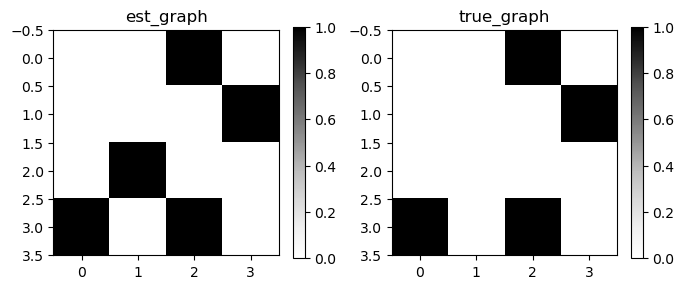

c:\Users\jakep\Coding\miniconda3\envs\causal_book_py39_cuda117\lib\site-packages\torch\distributions\distribution.py:53: UserWarning: <class 'causica.distributions.noise.joint.JointNoise'> does not define `arg_constraints`. Please set `arg_constraints = {}` or initialize the distribution with `validate_args=False` to turn off validation.
  warnings.warn(


epoch:100 loss:10.28 nll:10.275 dagness:0.67233 num_edges:5 alpha:0.67233 rho:1 step:1|186 num_lr_updates:0


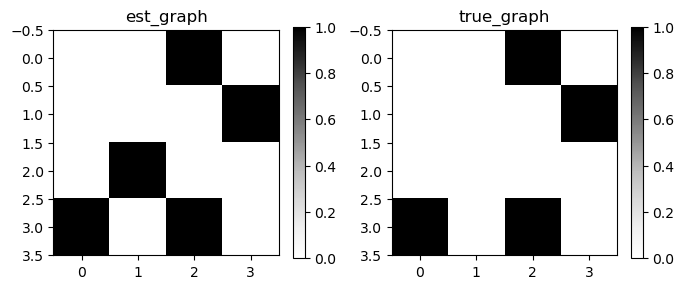

c:\Users\jakep\Coding\miniconda3\envs\causal_book_py39_cuda117\lib\site-packages\torch\distributions\distribution.py:53: UserWarning: <class 'causica.distributions.noise.joint.JointNoise'> does not define `arg_constraints`. Please set `arg_constraints = {}` or initialize the distribution with `validate_args=False` to turn off validation.
  warnings.warn(


epoch:110 loss:12.124 nll:12.12 dagness:0.67233 num_edges:5 alpha:0.67233 rho:1 step:1|286 num_lr_updates:0


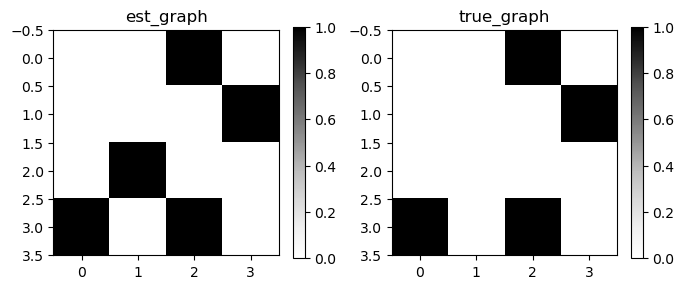

c:\Users\jakep\Coding\miniconda3\envs\causal_book_py39_cuda117\lib\site-packages\torch\distributions\distribution.py:53: UserWarning: <class 'causica.distributions.noise.joint.JointNoise'> does not define `arg_constraints`. Please set `arg_constraints = {}` or initialize the distribution with `validate_args=False` to turn off validation.
  warnings.warn(


epoch:120 loss:12.05 nll:12.045 dagness:0.67233 num_edges:5 alpha:0.67233 rho:1 step:1|386 num_lr_updates:0


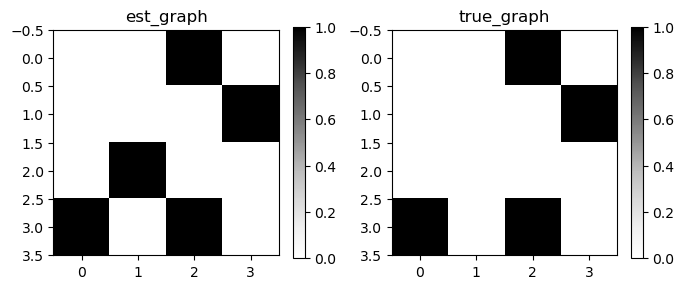

c:\Users\jakep\Coding\miniconda3\envs\causal_book_py39_cuda117\lib\site-packages\torch\distributions\distribution.py:53: UserWarning: <class 'causica.distributions.noise.joint.JointNoise'> does not define `arg_constraints`. Please set `arg_constraints = {}` or initialize the distribution with `validate_args=False` to turn off validation.
  warnings.warn(


epoch:130 loss:10.616 nll:10.611 dagness:0.67233 num_edges:5 alpha:0.67233 rho:1 step:1|486 num_lr_updates:0


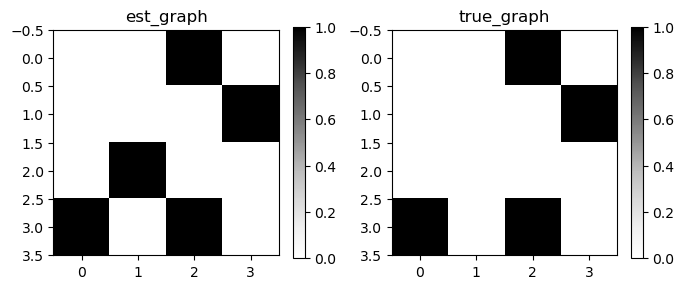

c:\Users\jakep\Coding\miniconda3\envs\causal_book_py39_cuda117\lib\site-packages\torch\distributions\distribution.py:53: UserWarning: <class 'causica.distributions.noise.joint.JointNoise'> does not define `arg_constraints`. Please set `arg_constraints = {}` or initialize the distribution with `validate_args=False` to turn off validation.
  warnings.warn(


Updating rho, dag penalty prev:  0.6723327637
epoch:140 loss:11.469 nll:11.464 dagness:0.67233 num_edges:5 alpha:0.67233 rho:10 step:2|66 num_lr_updates:0


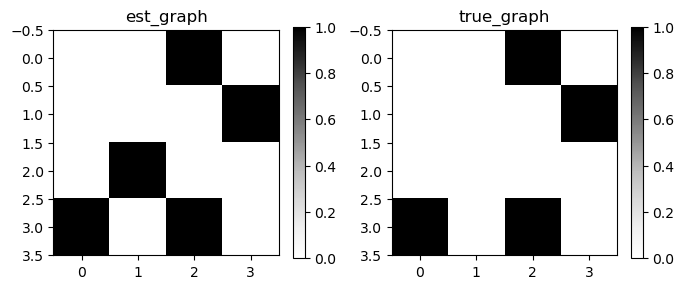

c:\Users\jakep\Coding\miniconda3\envs\causal_book_py39_cuda117\lib\site-packages\torch\distributions\distribution.py:53: UserWarning: <class 'causica.distributions.noise.joint.JointNoise'> does not define `arg_constraints`. Please set `arg_constraints = {}` or initialize the distribution with `validate_args=False` to turn off validation.
  warnings.warn(


epoch:150 loss:12.553 nll:12.548 dagness:0.67233 num_edges:5 alpha:0.67233 rho:10 step:2|166 num_lr_updates:0


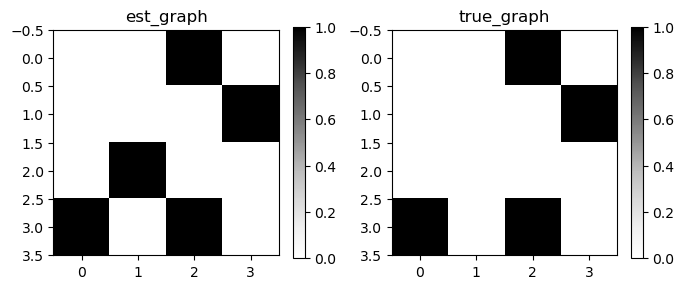

c:\Users\jakep\Coding\miniconda3\envs\causal_book_py39_cuda117\lib\site-packages\torch\distributions\distribution.py:53: UserWarning: <class 'causica.distributions.noise.joint.JointNoise'> does not define `arg_constraints`. Please set `arg_constraints = {}` or initialize the distribution with `validate_args=False` to turn off validation.
  warnings.warn(


epoch:160 loss:12.273 nll:12.269 dagness:0.00000 num_edges:4 alpha:0.67233 rho:10 step:2|266 num_lr_updates:0


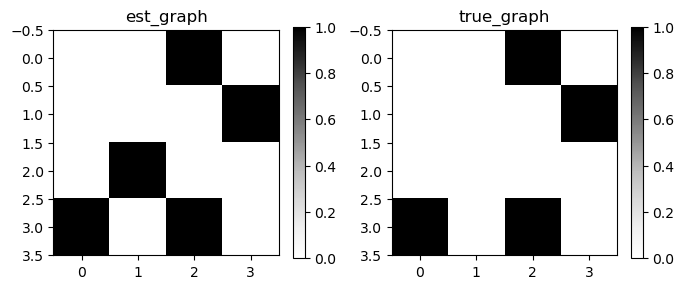

c:\Users\jakep\Coding\miniconda3\envs\causal_book_py39_cuda117\lib\site-packages\torch\distributions\distribution.py:53: UserWarning: <class 'causica.distributions.noise.joint.JointNoise'> does not define `arg_constraints`. Please set `arg_constraints = {}` or initialize the distribution with `validate_args=False` to turn off validation.
  warnings.warn(


epoch:170 loss:12.611 nll:12.607 dagness:0.67233 num_edges:5 alpha:0.67233 rho:10 step:2|366 num_lr_updates:0


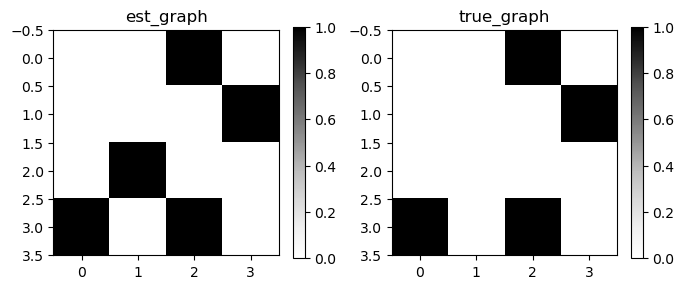

c:\Users\jakep\Coding\miniconda3\envs\causal_book_py39_cuda117\lib\site-packages\torch\distributions\distribution.py:53: UserWarning: <class 'causica.distributions.noise.joint.JointNoise'> does not define `arg_constraints`. Please set `arg_constraints = {}` or initialize the distribution with `validate_args=False` to turn off validation.
  warnings.warn(


epoch:180 loss:14.052 nll:14.047 dagness:0.00000 num_edges:5 alpha:0.67233 rho:10 step:2|466 num_lr_updates:0


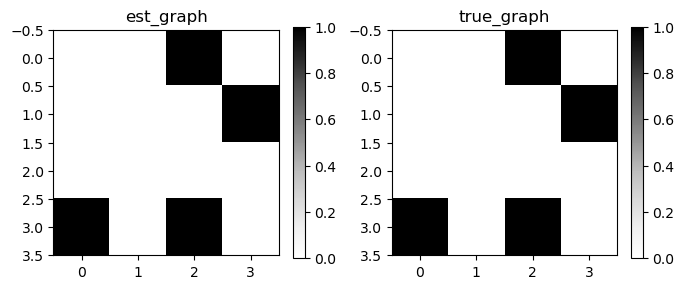

c:\Users\jakep\Coding\miniconda3\envs\causal_book_py39_cuda117\lib\site-packages\torch\distributions\distribution.py:53: UserWarning: <class 'causica.distributions.noise.joint.JointNoise'> does not define `arg_constraints`. Please set `arg_constraints = {}` or initialize the distribution with `validate_args=False` to turn off validation.
  warnings.warn(


Updating alpha to: 3.361663818359375
epoch:190 loss:13.87 nll:13.866 dagness:0.00000 num_edges:4 alpha:3.3617 rho:10 step:3|17 num_lr_updates:0


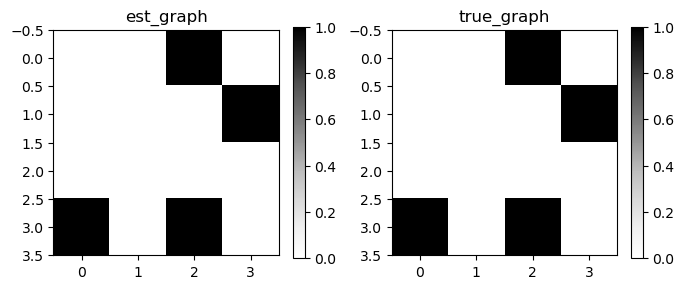

c:\Users\jakep\Coding\miniconda3\envs\causal_book_py39_cuda117\lib\site-packages\torch\distributions\distribution.py:53: UserWarning: <class 'causica.distributions.noise.joint.JointNoise'> does not define `arg_constraints`. Please set `arg_constraints = {}` or initialize the distribution with `validate_args=False` to turn off validation.
  warnings.warn(


epoch:200 loss:12.508 nll:12.505 dagness:0.00000 num_edges:4 alpha:3.3617 rho:10 step:3|117 num_lr_updates:0


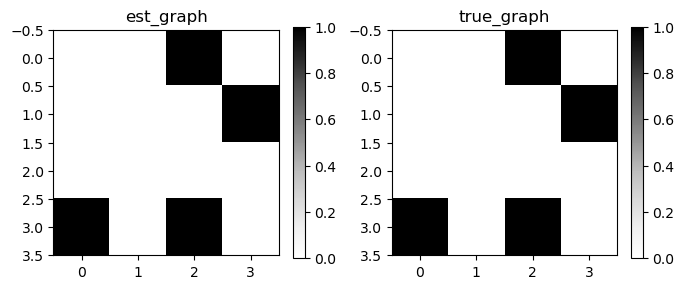

c:\Users\jakep\Coding\miniconda3\envs\causal_book_py39_cuda117\lib\site-packages\torch\distributions\distribution.py:53: UserWarning: <class 'causica.distributions.noise.joint.JointNoise'> does not define `arg_constraints`. Please set `arg_constraints = {}` or initialize the distribution with `validate_args=False` to turn off validation.
  warnings.warn(


epoch:210 loss:11.244 nll:11.237 dagness:2.36806 num_edges:6 alpha:3.3617 rho:10 step:3|217 num_lr_updates:0


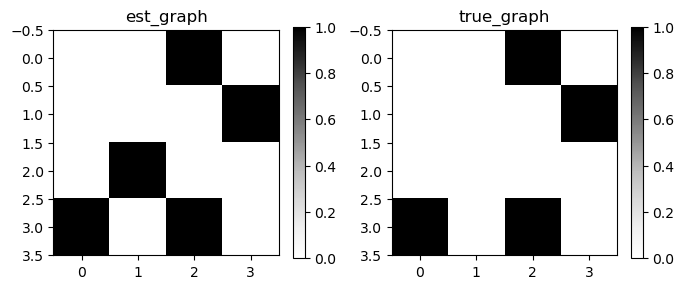

c:\Users\jakep\Coding\miniconda3\envs\causal_book_py39_cuda117\lib\site-packages\torch\distributions\distribution.py:53: UserWarning: <class 'causica.distributions.noise.joint.JointNoise'> does not define `arg_constraints`. Please set `arg_constraints = {}` or initialize the distribution with `validate_args=False` to turn off validation.
  warnings.warn(


epoch:220 loss:12.171 nll:12.166 dagness:0.67233 num_edges:5 alpha:3.3617 rho:10 step:3|317 num_lr_updates:0


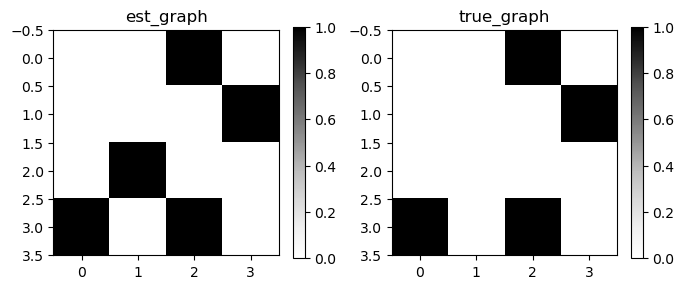

c:\Users\jakep\Coding\miniconda3\envs\causal_book_py39_cuda117\lib\site-packages\torch\distributions\distribution.py:53: UserWarning: <class 'causica.distributions.noise.joint.JointNoise'> does not define `arg_constraints`. Please set `arg_constraints = {}` or initialize the distribution with `validate_args=False` to turn off validation.
  warnings.warn(


epoch:230 loss:12.921 nll:12.916 dagness:0.67233 num_edges:5 alpha:3.3617 rho:10 step:3|417 num_lr_updates:0


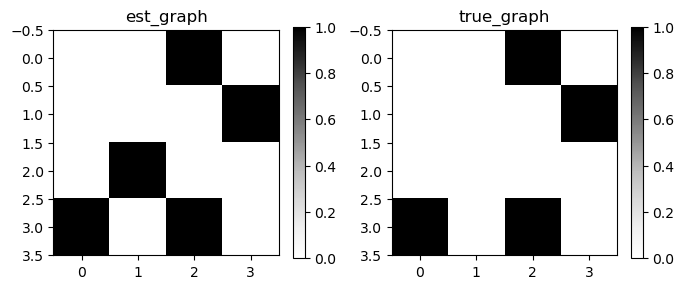

c:\Users\jakep\Coding\miniconda3\envs\causal_book_py39_cuda117\lib\site-packages\torch\distributions\distribution.py:53: UserWarning: <class 'causica.distributions.noise.joint.JointNoise'> does not define `arg_constraints`. Please set `arg_constraints = {}` or initialize the distribution with `validate_args=False` to turn off validation.
  warnings.warn(


epoch:240 loss:13.646 nll:13.641 dagness:0.67233 num_edges:5 alpha:3.3617 rho:10 step:3|517 num_lr_updates:1


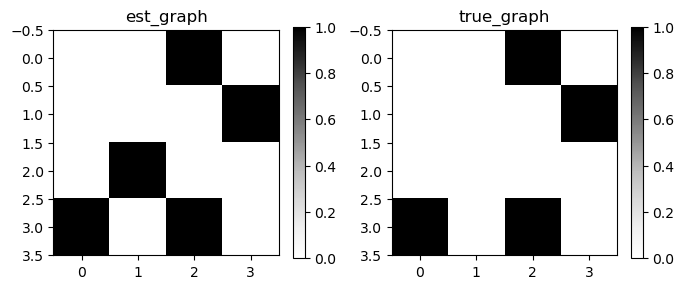

c:\Users\jakep\Coding\miniconda3\envs\causal_book_py39_cuda117\lib\site-packages\torch\distributions\distribution.py:53: UserWarning: <class 'causica.distributions.noise.joint.JointNoise'> does not define `arg_constraints`. Please set `arg_constraints = {}` or initialize the distribution with `validate_args=False` to turn off validation.
  warnings.warn(


epoch:250 loss:13.493 nll:13.487 dagness:0.67233 num_edges:5 alpha:3.3617 rho:10 step:3|617 num_lr_updates:1


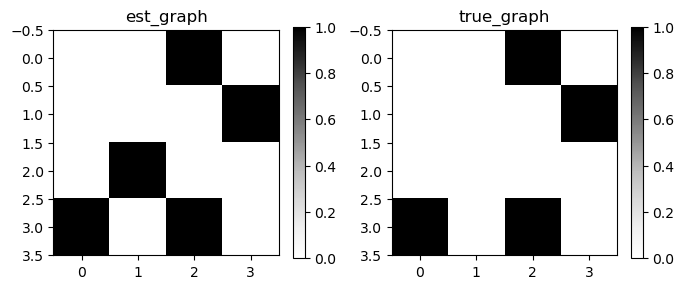

c:\Users\jakep\Coding\miniconda3\envs\causal_book_py39_cuda117\lib\site-packages\torch\distributions\distribution.py:53: UserWarning: <class 'causica.distributions.noise.joint.JointNoise'> does not define `arg_constraints`. Please set `arg_constraints = {}` or initialize the distribution with `validate_args=False` to turn off validation.
  warnings.warn(


Updating rho, dag penalty prev:  0.0000000000
epoch:260 loss:13.282 nll:13.276 dagness:0.67233 num_edges:5 alpha:3.3617 rho:100 step:4|49 num_lr_updates:0


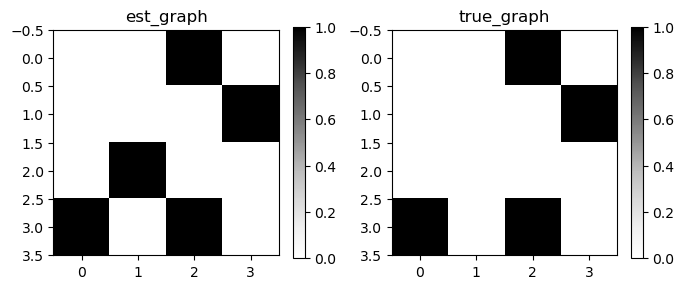

c:\Users\jakep\Coding\miniconda3\envs\causal_book_py39_cuda117\lib\site-packages\torch\distributions\distribution.py:53: UserWarning: <class 'causica.distributions.noise.joint.JointNoise'> does not define `arg_constraints`. Please set `arg_constraints = {}` or initialize the distribution with `validate_args=False` to turn off validation.
  warnings.warn(


epoch:270 loss:13.296 nll:13.29 dagness:0.67233 num_edges:5 alpha:3.3617 rho:100 step:4|149 num_lr_updates:0


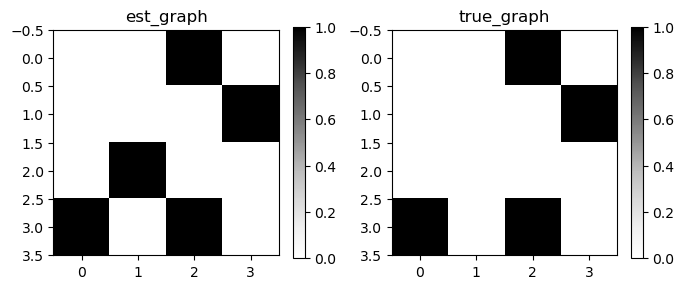

c:\Users\jakep\Coding\miniconda3\envs\causal_book_py39_cuda117\lib\site-packages\torch\distributions\distribution.py:53: UserWarning: <class 'causica.distributions.noise.joint.JointNoise'> does not define `arg_constraints`. Please set `arg_constraints = {}` or initialize the distribution with `validate_args=False` to turn off validation.
  warnings.warn(


epoch:280 loss:13.025 nll:13.02 dagness:0.67233 num_edges:5 alpha:3.3617 rho:100 step:4|249 num_lr_updates:0


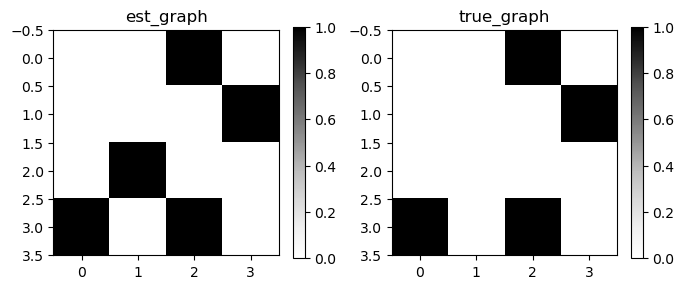

c:\Users\jakep\Coding\miniconda3\envs\causal_book_py39_cuda117\lib\site-packages\torch\distributions\distribution.py:53: UserWarning: <class 'causica.distributions.noise.joint.JointNoise'> does not define `arg_constraints`. Please set `arg_constraints = {}` or initialize the distribution with `validate_args=False` to turn off validation.
  warnings.warn(


epoch:290 loss:13.123 nll:13.118 dagness:0.67233 num_edges:5 alpha:3.3617 rho:100 step:4|349 num_lr_updates:0


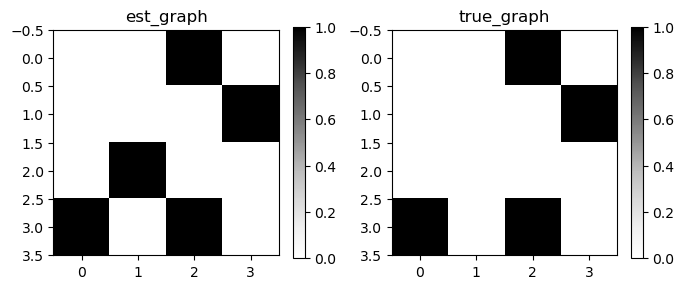

c:\Users\jakep\Coding\miniconda3\envs\causal_book_py39_cuda117\lib\site-packages\torch\distributions\distribution.py:53: UserWarning: <class 'causica.distributions.noise.joint.JointNoise'> does not define `arg_constraints`. Please set `arg_constraints = {}` or initialize the distribution with `validate_args=False` to turn off validation.
  warnings.warn(


epoch:300 loss:13.107 nll:13.1 dagness:1.81037 num_edges:6 alpha:3.3617 rho:100 step:4|449 num_lr_updates:0


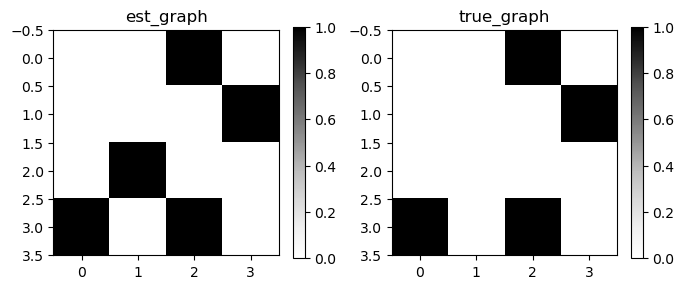

c:\Users\jakep\Coding\miniconda3\envs\causal_book_py39_cuda117\lib\site-packages\torch\distributions\distribution.py:53: UserWarning: <class 'causica.distributions.noise.joint.JointNoise'> does not define `arg_constraints`. Please set `arg_constraints = {}` or initialize the distribution with `validate_args=False` to turn off validation.
  warnings.warn(


epoch:310 loss:13.236 nll:13.231 dagness:0.67233 num_edges:5 alpha:3.3617 rho:100 step:4|549 num_lr_updates:0


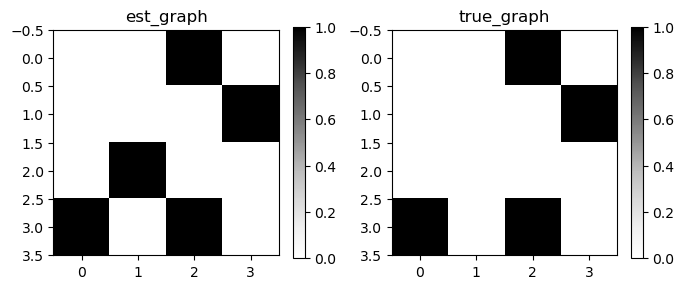

c:\Users\jakep\Coding\miniconda3\envs\causal_book_py39_cuda117\lib\site-packages\torch\distributions\distribution.py:53: UserWarning: <class 'causica.distributions.noise.joint.JointNoise'> does not define `arg_constraints`. Please set `arg_constraints = {}` or initialize the distribution with `validate_args=False` to turn off validation.
  warnings.warn(


epoch:320 loss:13.378 nll:13.372 dagness:0.67233 num_edges:5 alpha:3.3617 rho:100 step:4|649 num_lr_updates:1


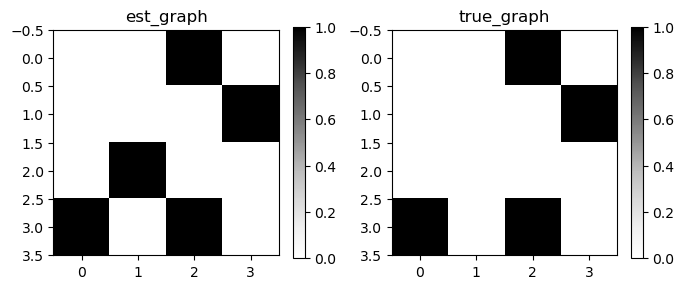

c:\Users\jakep\Coding\miniconda3\envs\causal_book_py39_cuda117\lib\site-packages\torch\distributions\distribution.py:53: UserWarning: <class 'causica.distributions.noise.joint.JointNoise'> does not define `arg_constraints`. Please set `arg_constraints = {}` or initialize the distribution with `validate_args=False` to turn off validation.
  warnings.warn(


epoch:330 loss:13.38 nll:13.375 dagness:0.67233 num_edges:5 alpha:3.3617 rho:100 step:4|749 num_lr_updates:1


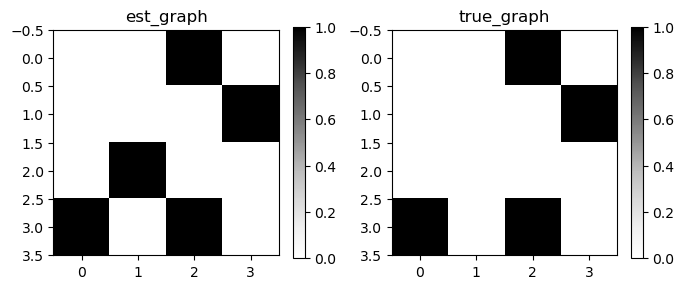

c:\Users\jakep\Coding\miniconda3\envs\causal_book_py39_cuda117\lib\site-packages\torch\distributions\distribution.py:53: UserWarning: <class 'causica.distributions.noise.joint.JointNoise'> does not define `arg_constraints`. Please set `arg_constraints = {}` or initialize the distribution with `validate_args=False` to turn off validation.
  warnings.warn(


epoch:340 loss:12.911 nll:12.906 dagness:0.67233 num_edges:5 alpha:3.3617 rho:100 step:4|849 num_lr_updates:1


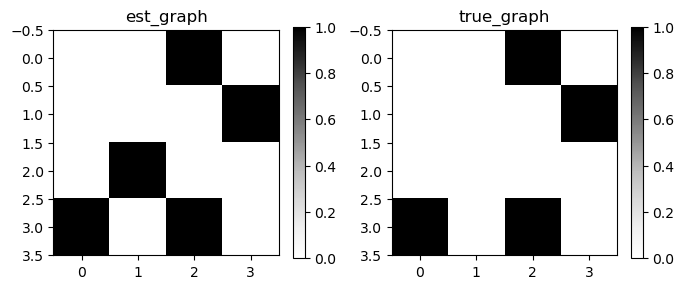

c:\Users\jakep\Coding\miniconda3\envs\causal_book_py39_cuda117\lib\site-packages\torch\distributions\distribution.py:53: UserWarning: <class 'causica.distributions.noise.joint.JointNoise'> does not define `arg_constraints`. Please set `arg_constraints = {}` or initialize the distribution with `validate_args=False` to turn off validation.
  warnings.warn(


Updating rho, dag penalty prev:  0.0000000000
epoch:350 loss:12.914 nll:12.909 dagness:0.67233 num_edges:5 alpha:3.3617 rho:1000 step:5|69 num_lr_updates:0


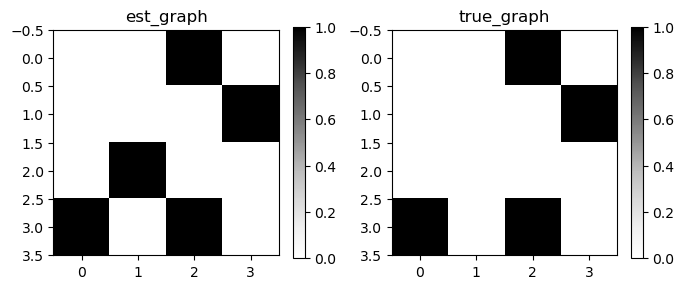

c:\Users\jakep\Coding\miniconda3\envs\causal_book_py39_cuda117\lib\site-packages\torch\distributions\distribution.py:53: UserWarning: <class 'causica.distributions.noise.joint.JointNoise'> does not define `arg_constraints`. Please set `arg_constraints = {}` or initialize the distribution with `validate_args=False` to turn off validation.
  warnings.warn(


epoch:360 loss:12.885 nll:12.879 dagness:0.67233 num_edges:5 alpha:3.3617 rho:1000 step:5|169 num_lr_updates:0


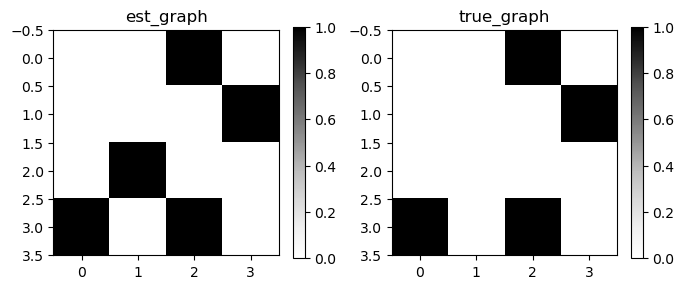

c:\Users\jakep\Coding\miniconda3\envs\causal_book_py39_cuda117\lib\site-packages\torch\distributions\distribution.py:53: UserWarning: <class 'causica.distributions.noise.joint.JointNoise'> does not define `arg_constraints`. Please set `arg_constraints = {}` or initialize the distribution with `validate_args=False` to turn off validation.
  warnings.warn(


epoch:370 loss:13.018 nll:13.014 dagness:0.00000 num_edges:4 alpha:3.3617 rho:1000 step:5|269 num_lr_updates:0


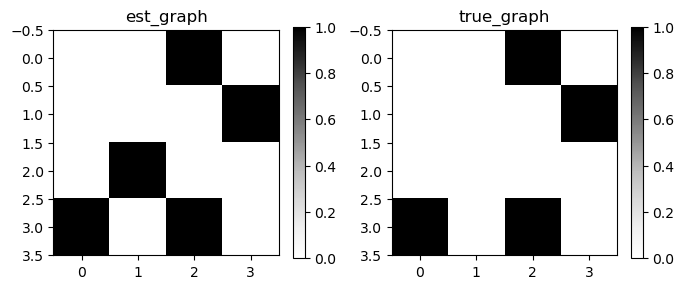

c:\Users\jakep\Coding\miniconda3\envs\causal_book_py39_cuda117\lib\site-packages\torch\distributions\distribution.py:53: UserWarning: <class 'causica.distributions.noise.joint.JointNoise'> does not define `arg_constraints`. Please set `arg_constraints = {}` or initialize the distribution with `validate_args=False` to turn off validation.
  warnings.warn(


epoch:380 loss:13.093 nll:13.087 dagness:0.67233 num_edges:5 alpha:3.3617 rho:1000 step:5|369 num_lr_updates:0


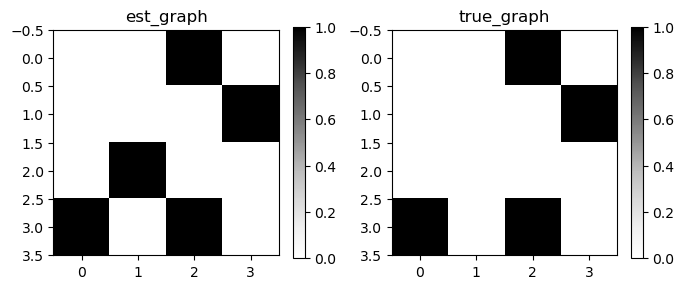

c:\Users\jakep\Coding\miniconda3\envs\causal_book_py39_cuda117\lib\site-packages\torch\distributions\distribution.py:53: UserWarning: <class 'causica.distributions.noise.joint.JointNoise'> does not define `arg_constraints`. Please set `arg_constraints = {}` or initialize the distribution with `validate_args=False` to turn off validation.
  warnings.warn(


epoch:390 loss:13.302 nll:13.296 dagness:0.67233 num_edges:5 alpha:3.3617 rho:1000 step:5|469 num_lr_updates:0


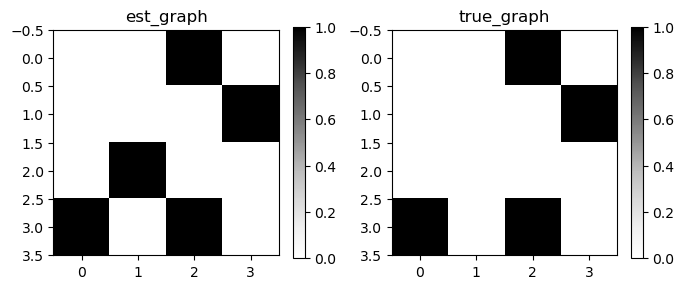

c:\Users\jakep\Coding\miniconda3\envs\causal_book_py39_cuda117\lib\site-packages\torch\distributions\distribution.py:53: UserWarning: <class 'causica.distributions.noise.joint.JointNoise'> does not define `arg_constraints`. Please set `arg_constraints = {}` or initialize the distribution with `validate_args=False` to turn off validation.
  warnings.warn(


epoch:400 loss:13.428 nll:13.423 dagness:0.67233 num_edges:5 alpha:3.3617 rho:1000 step:5|569 num_lr_updates:1


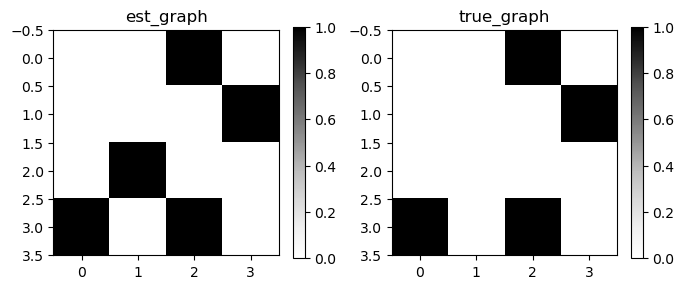

c:\Users\jakep\Coding\miniconda3\envs\causal_book_py39_cuda117\lib\site-packages\torch\distributions\distribution.py:53: UserWarning: <class 'causica.distributions.noise.joint.JointNoise'> does not define `arg_constraints`. Please set `arg_constraints = {}` or initialize the distribution with `validate_args=False` to turn off validation.
  warnings.warn(


epoch:410 loss:12.938 nll:12.932 dagness:0.67233 num_edges:5 alpha:3.3617 rho:1000 step:5|669 num_lr_updates:1


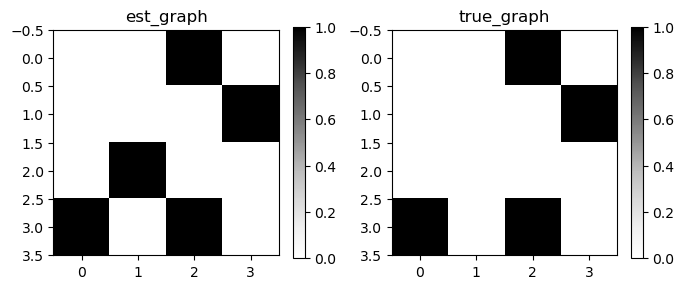

c:\Users\jakep\Coding\miniconda3\envs\causal_book_py39_cuda117\lib\site-packages\torch\distributions\distribution.py:53: UserWarning: <class 'causica.distributions.noise.joint.JointNoise'> does not define `arg_constraints`. Please set `arg_constraints = {}` or initialize the distribution with `validate_args=False` to turn off validation.
  warnings.warn(


epoch:420 loss:13.24 nll:13.235 dagness:0.67233 num_edges:5 alpha:3.3617 rho:1000 step:5|769 num_lr_updates:1


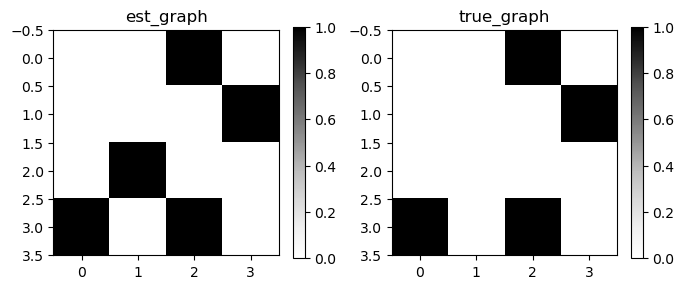

c:\Users\jakep\Coding\miniconda3\envs\causal_book_py39_cuda117\lib\site-packages\torch\distributions\distribution.py:53: UserWarning: <class 'causica.distributions.noise.joint.JointNoise'> does not define `arg_constraints`. Please set `arg_constraints = {}` or initialize the distribution with `validate_args=False` to turn off validation.
  warnings.warn(


epoch:430 loss:13.311 nll:13.306 dagness:0.67233 num_edges:5 alpha:3.3617 rho:1000 step:5|869 num_lr_updates:1


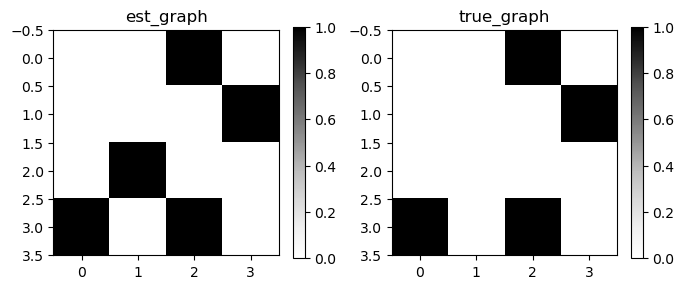

c:\Users\jakep\Coding\miniconda3\envs\causal_book_py39_cuda117\lib\site-packages\torch\distributions\distribution.py:53: UserWarning: <class 'causica.distributions.noise.joint.JointNoise'> does not define `arg_constraints`. Please set `arg_constraints = {}` or initialize the distribution with `validate_args=False` to turn off validation.
  warnings.warn(


epoch:440 loss:13.08 nll:13.075 dagness:0.67233 num_edges:5 alpha:3.3617 rho:1000 step:5|969 num_lr_updates:1


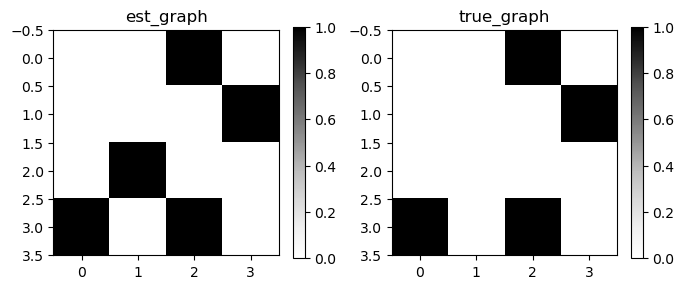

c:\Users\jakep\Coding\miniconda3\envs\causal_book_py39_cuda117\lib\site-packages\torch\distributions\distribution.py:53: UserWarning: <class 'causica.distributions.noise.joint.JointNoise'> does not define `arg_constraints`. Please set `arg_constraints = {}` or initialize the distribution with `validate_args=False` to turn off validation.
  warnings.warn(


Updating rho, dag penalty prev:  0.0000000000
epoch:450 loss:12.934 nll:12.929 dagness:0.67233 num_edges:5 alpha:3.3617 rho:10000 step:6|67 num_lr_updates:0


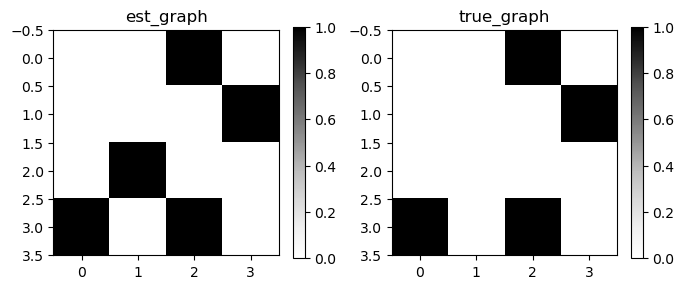

c:\Users\jakep\Coding\miniconda3\envs\causal_book_py39_cuda117\lib\site-packages\torch\distributions\distribution.py:53: UserWarning: <class 'causica.distributions.noise.joint.JointNoise'> does not define `arg_constraints`. Please set `arg_constraints = {}` or initialize the distribution with `validate_args=False` to turn off validation.
  warnings.warn(


epoch:460 loss:13.321 nll:13.315 dagness:0.67233 num_edges:5 alpha:3.3617 rho:10000 step:6|167 num_lr_updates:0


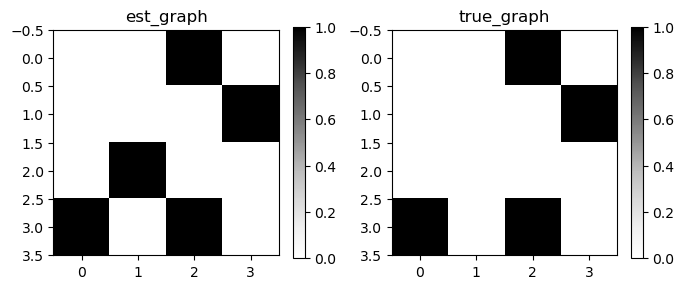

c:\Users\jakep\Coding\miniconda3\envs\causal_book_py39_cuda117\lib\site-packages\torch\distributions\distribution.py:53: UserWarning: <class 'causica.distributions.noise.joint.JointNoise'> does not define `arg_constraints`. Please set `arg_constraints = {}` or initialize the distribution with `validate_args=False` to turn off validation.
  warnings.warn(


epoch:470 loss:13.21 nll:13.205 dagness:0.67233 num_edges:5 alpha:3.3617 rho:10000 step:6|267 num_lr_updates:0


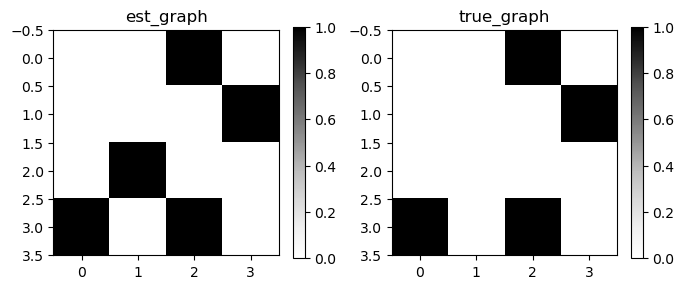

c:\Users\jakep\Coding\miniconda3\envs\causal_book_py39_cuda117\lib\site-packages\torch\distributions\distribution.py:53: UserWarning: <class 'causica.distributions.noise.joint.JointNoise'> does not define `arg_constraints`. Please set `arg_constraints = {}` or initialize the distribution with `validate_args=False` to turn off validation.
  warnings.warn(


epoch:480 loss:13.03 nll:13.024 dagness:0.67233 num_edges:5 alpha:3.3617 rho:10000 step:6|367 num_lr_updates:0


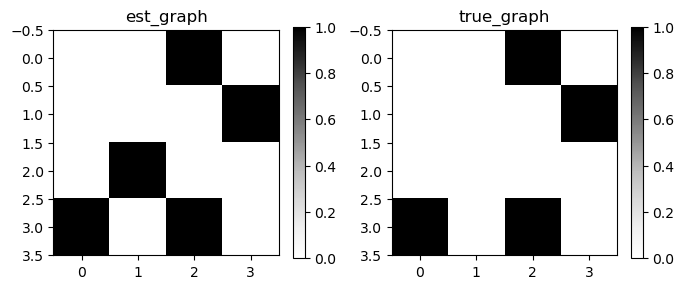

c:\Users\jakep\Coding\miniconda3\envs\causal_book_py39_cuda117\lib\site-packages\torch\distributions\distribution.py:53: UserWarning: <class 'causica.distributions.noise.joint.JointNoise'> does not define `arg_constraints`. Please set `arg_constraints = {}` or initialize the distribution with `validate_args=False` to turn off validation.
  warnings.warn(


epoch:490 loss:12.939 nll:12.933 dagness:0.67233 num_edges:5 alpha:3.3617 rho:10000 step:6|467 num_lr_updates:0


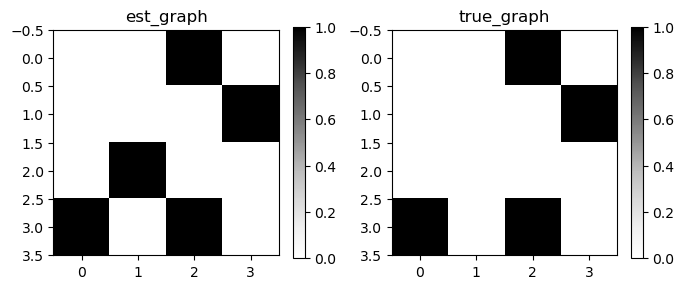

c:\Users\jakep\Coding\miniconda3\envs\causal_book_py39_cuda117\lib\site-packages\torch\distributions\distribution.py:53: UserWarning: <class 'causica.distributions.noise.joint.JointNoise'> does not define `arg_constraints`. Please set `arg_constraints = {}` or initialize the distribution with `validate_args=False` to turn off validation.
  warnings.warn(


In [162]:
assert len(dataset_train.batch_size) == 1, "Only 1D batch size is supported"

num_samples = len(dataset_train)

for epoch in range(training_config.max_epoch):
    
    for i, batch in enumerate(dataloader_train):
        
        # Zero the gradients
        optimizer.zero_grad()
        
        # Get SEM 
        sem_distribution = sem_module()
        sem, *_ = sem_distribution.relaxed_sample(
            torch.Size([]), 
            temperature=training_config.gumbel_temp
        )  # soft sample
        
        # Compute the log probability of data
        batch_log_prob = sem.log_prob(batch).mean()
        
        # Get the distribution entropy
        sem_distribution_entropy = sem_distribution.entropy()
        
        # Compute the likelihood of the current graph
        prior_term = prior.log_prob(sem.graph)
        
        # Compute the objective
        objective = (-sem_distribution_entropy - prior_term) / num_samples - batch_log_prob
        
        # Compute the DAG-ness term
        constraint = calculate_dagness(sem.graph)
        
        # Compute the Lagrangian loss
        loss = auglag_loss(objective, constraint / num_samples)

        # Propagate gradients and update
        loss.backward()
        optimizer.step()
        
        # Update the Auglag parameters
        scheduler.step(
            optimizer=optimizer,
            loss=auglag_loss,
            loss_value=loss.item(),
            lagrangian_penalty=constraint.item(),
        )
        
        # Log metrics & plot the matrices
        if epoch % 10 == 0 and i == 0:
            print(
                f"epoch:{epoch} loss:{loss.item():.5g} nll:{-batch_log_prob.detach().cpu().numpy():.5g} "
                f"dagness:{constraint.item():.5f} num_edges:{(sem.graph > 0.0).sum()} "
                f"alpha:{auglag_loss.alpha:.5g} rho:{auglag_loss.rho:.5g} "
                f"step:{scheduler.outer_opt_counter}|{scheduler.step_counter} "
                f"num_lr_updates:{scheduler.num_lr_updates}"
            )
            
            vardist = adjacency_dist()
            pred_dag = vardist.mode.cpu().numpy()

            plt.style.use('default')

            GraphDAG(
                est_dag=pred_dag, 
                true_dag=adj_matrix)

            plt.show()

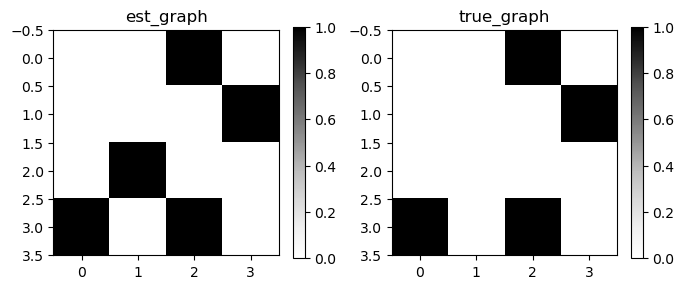

In [163]:
# Sample from the distribution of graphs
vardist = adjacency_dist()
pred_dag = vardist.mode.cpu().numpy()


# Plot the final graph vs the ground truth
plt.style.use('default')

GraphDAG(
    est_dag=pred_dag, 
    true_dag=adj_matrix)

plt.show()

In [164]:
# Compute and print the metrics
metrics = MetricsDAG(
    B_est=pred_dag, 
    B_true=adj_matrix)

metrics.metrics

{'fdr': 0.2,
 'tpr': 1.0,
 'fpr': 0.5,
 'shd': 1,
 'nnz': 5,
 'precision': 0.8,
 'recall': 1.0,
 'F1': 0.8889,
 'gscore': 0.75}

## Causal discovery under hidden confounding

In [165]:
from causallearn.search.ConstraintBased.FCI import fci
from causallearn.graph.GraphNode import GraphNode
from causallearn.utils.PCUtils.BackgroundKnowledge import BackgroundKnowledge

### Data

In [166]:
# Generate confounded data
N = 1000

q = np.random.uniform(0, 2, N)
w = np.random.randn(N)
x = np.random.gumbel(0, 1, N) + w
y = 0.6 * q + 0.8 * w + np.random.uniform(0, 1, N)
z = 0.5 * x + np.random.randn(N)


data = np.stack([x, y, w, z, q]).T
confounded_data = np.stack([x, y, z, q]).T

In [167]:
# Create the true graph
nodes = ['X', 'Y', 'W', 'Z', 'Q']

edges = [
    ('W', 'X'),
    ('W', 'Y'),
    ('Q', 'Y'),
    ('X', 'Z'),
]

fci_graph = nx.DiGraph()

fci_graph.add_nodes_from(nodes)
fci_graph.add_edges_from(edges)

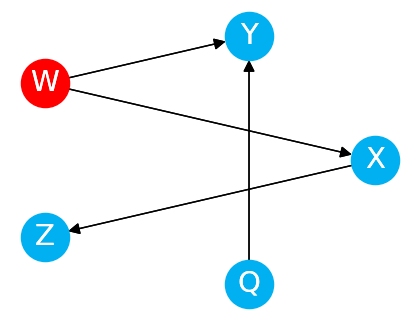

In [168]:
# Plot the graph
plt.figure(figsize=(4, 3))

nx.draw(
    G=fci_graph,
    node_color=COLORS[0],
    node_size=1200,
    nodelist=['X', 'Y', 'Z', 'Q'],
    arrowsize=17,
    with_labels=True,
    font_color='white',
    font_size=21,
    pos=nx.circular_layout(fci_graph)
)
nx.draw(
    G=fci_graph,
    node_color=COLORS[1],
    node_size=1200,
    nodelist=['W'],
    arrowsize=17,
    with_labels=True,
    font_color='white',
    font_size=21,
    pos=nx.circular_layout(fci_graph)
)

### Model 

In [169]:
# Train FCI and get the graph
g, edges = fci(
    dataset=confounded_data, 
    independence_test_method='kci'
)

Depth=0, working on node 0:  25%|██▌       | 1/4 [00:00<00:00, 1002.70it/s]

Depth=1, working on node 3: 100%|██████████| 4/4 [00:03<00:00,  1.11it/s]  


In [170]:
# Ordering: [x, y, z, q]
g.graph

array([[0, 2, 2, 0],
       [1, 0, 0, 1],
       [2, 0, 0, 0],
       [0, 2, 0, 0]])

In [171]:
mapping = {
    'X1': 'X',
    'X2': 'Y',
    'X3': 'Z',
    'X4': 'Q'
}

for edge in edges:
    mapped = str(edge)\
        .replace(str(edge.node1), mapping[str(edge.node1)])\
        .replace(str(edge.node2), mapping[str(edge.node2)])
    print(mapped)

X o-> Y
X o-o Z
Q o-> Y


In [172]:
str(edge), str(edge.node1)

('X4 o-> X2', 'X4')

### Model with prior knowledge

In [173]:
# Add prior knowledge
prior_knowledge = BackgroundKnowledge()
prior_knowledge.add_forbidden_by_node(GraphNode('X2'), GraphNode('X4'))
prior_knowledge.add_required_by_node(GraphNode('X1'), GraphNode('X3'))

g, edges = fci(
    dataset=confounded_data, 
    independence_test_method='fisherz',
    background_knowledge=prior_knowledge
)

Depth=1, working on node 3: 100%|██████████| 4/4 [00:00<00:00, 572.93it/s] 

Starting BK Orientation.
Orienting edge (Knowledge): X1 --> X3
Orienting edge (Knowledge): X4 --> X2
Finishing BK Orientation.
Starting BK Orientation.
Orienting edge (Knowledge): X1 --> X3
Orienting edge (Knowledge): X4 --> X2
Finishing BK Orientation.


In [174]:
for edge in edges:
    mapped = str(edge)\
        .replace(str(edge.node1), mapping[str(edge.node1)])\
        .replace(str(edge.node2), mapping[str(edge.node2)])
    print(mapped)

X o-> Y
X --> Z
Q --> Y
